# Predicting breast cancer project

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


## INTRODUCTION 

*Background* 

*Question* 

*Dataset Description*
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

*Data sources*

https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29


## EDA

*Reading the data into Notebook* 

Since the dataset did not come with column headers, we will first manually add them. The headers will correspond to the order of their respective description above.

In [2]:
col_names = ["id", "clump", "unif_size", "unif_shape", "adhesion", "epi_size",
             "nuclei", "chromatin", "nucleoli", "mitoses", "class"]

dataset = pd.read_csv("breast_cancer.txt", names=col_names, sep=",")

In [3]:
dataset.head()

,id,clump,unif_size,unif_shape,adhesion,epi_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          699 non-null    int64 
 1   clump       699 non-null    int64 
 2   unif_size   699 non-null    int64 
 3   unif_shape  699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epi_size    699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


We see that the dataset uses "?" for missing data so we eliminate rows that contain "?". Above all of the variables are numeric except for variables nuclei, we decide to transform it into int64 for ease of data analysis later on. Finally, "id" feature does not appear to be useful for the prediction task; hence, it is decided to be dropped before carrying on to further analysis. 

In [6]:
dataset = dataset[(dataset != '?').all(axis=1)]
dataset['nuclei'] = dataset['nuclei'].astype(int)
dataset = dataset.drop(columns=["id"])

C:\Users\kimpd\AppData\Local\Temp\ipykernel_18364\1067720722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['nuclei'] = dataset['nuclei'].astype(int)


We also decide to replace benign class from 2 to 0 and malignant class from 4 to 1 since if we keep values of 2 and 4, it would be hard for predictive models to calculate accuracy, precision, and so on. 

In [7]:
dataset['class'] = dataset['class'].replace([2],0)
dataset['class'] = dataset['class'].replace([4],1) 
dataset['class'].value_counts(normalize = True)
  

0    0.650073
1    0.349927
Name: class, dtype: float64

There is an imbalance in the dataset between benign and malignant. We want to further investigate the malignant examples (class = 4); hence the classes should have same importance so recall would be the most appropriate metric for this project.

Then we split the data into training and testing sets (X_train, X_test, y_train, y_test) for further exploration. 
 

In [8]:
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=123)
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 696 to 525
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   clump       478 non-null    int64
 1   unif_size   478 non-null    int64
 2   unif_shape  478 non-null    int64
 3   adhesion    478 non-null    int64
 4   epi_size    478 non-null    int64
 5   nuclei      478 non-null    int32
 6   chromatin   478 non-null    int64
 7   nucleoli    478 non-null    int64
 8   mitoses     478 non-null    int64
 9   class       478 non-null    int64
dtypes: int32(1), int64(9)
memory usage: 39.2 KB


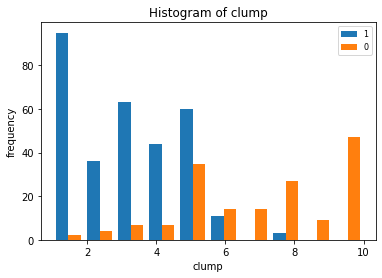

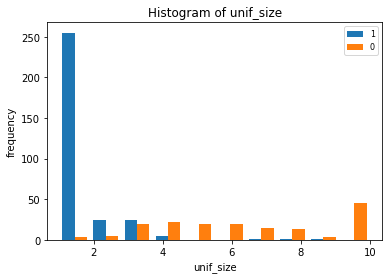

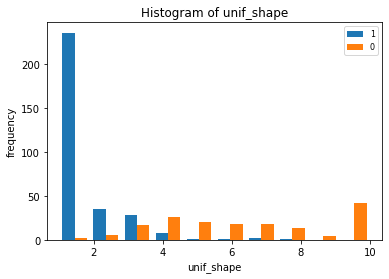

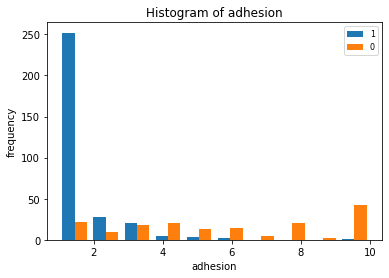

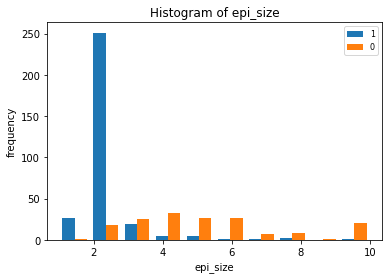

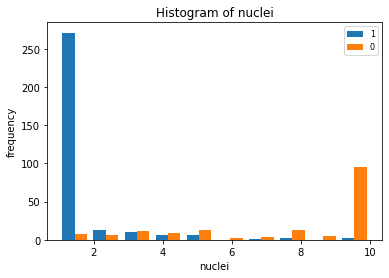

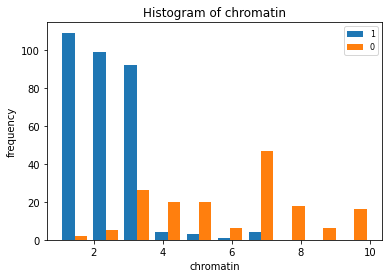

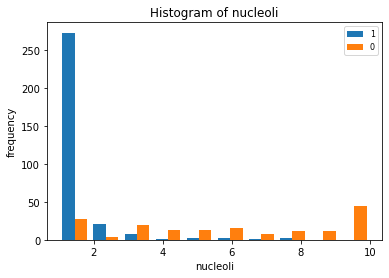

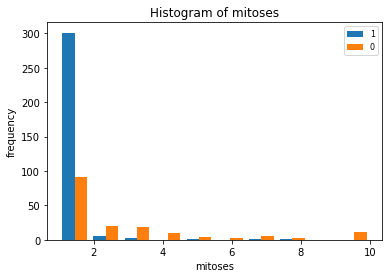

In [9]:
benign_cases = train_df[train_df["class"] == 0]
                    
malignant_cases = train_df[train_df["class"] == 1]

def plots(): 
    for x in numeric_looking_columns:
        x1 = benign_cases[x]
        y1 = malignant_cases[x]
        plt.hist([x1, y1], label=['1', '0'])
        plt.title('Histogram of ' + x)
        plt.xlabel(x)
        plt.ylabel('frequency')
        plt.legend(loc='upper right', fontsize = 8)
        plt.show()

plots()

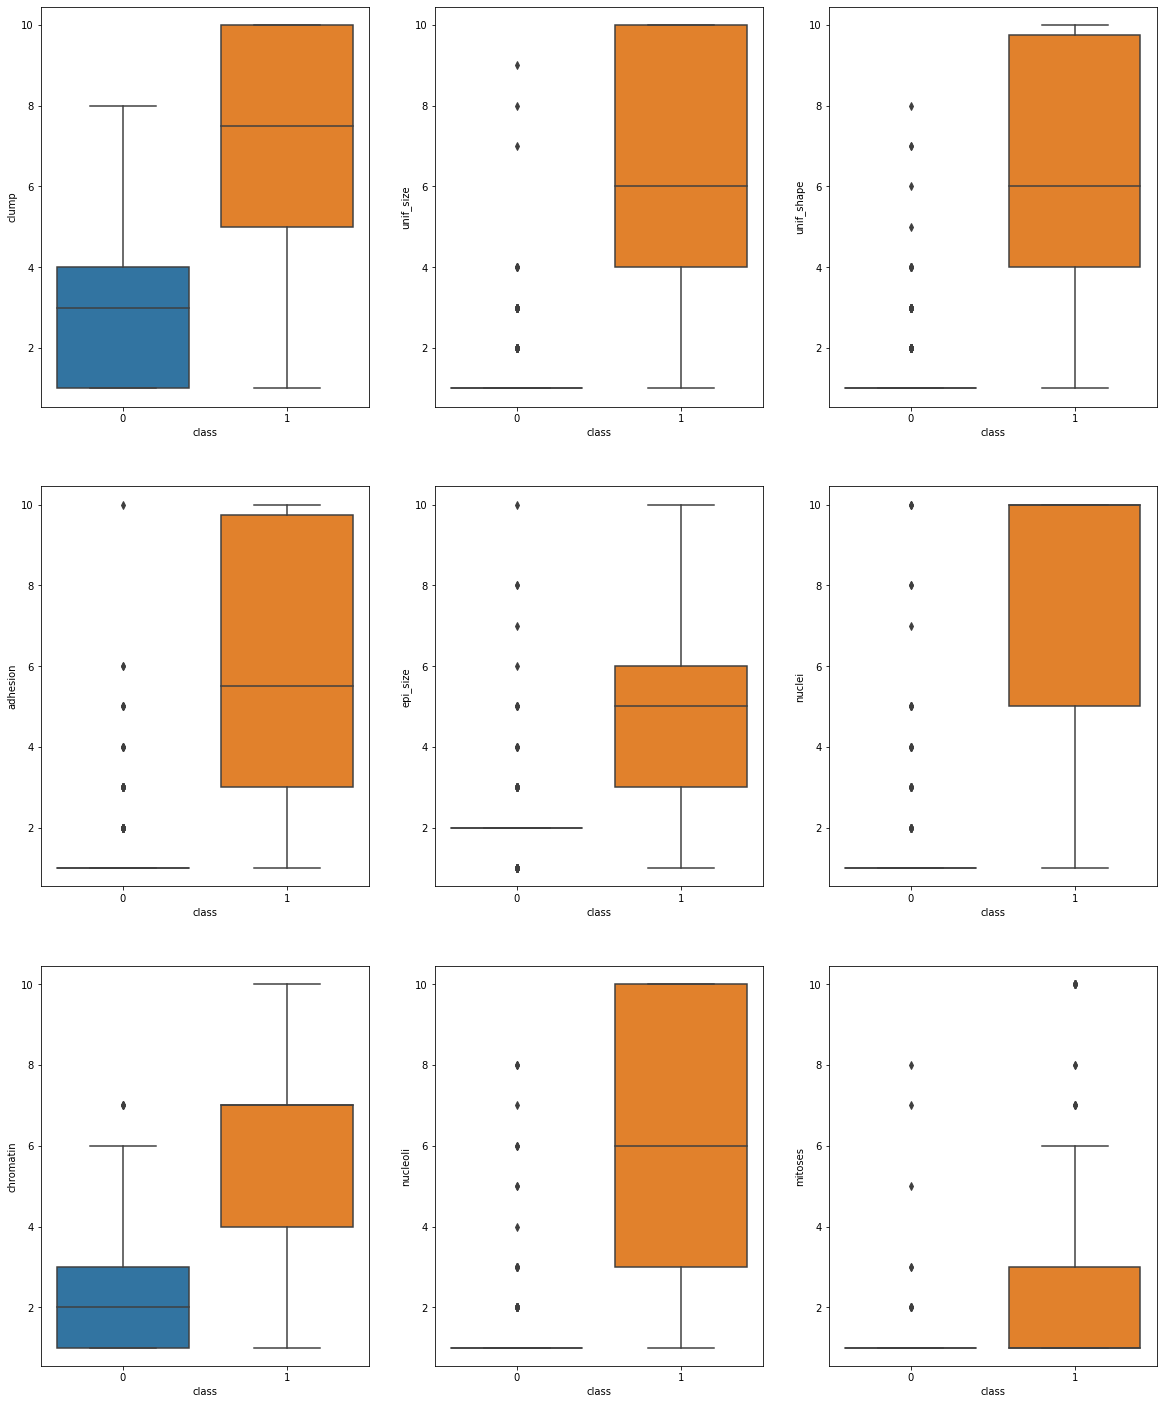

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(20, 25))
for var, subplot in zip(numeric_looking_columns, ax.flatten()):
    sns.boxplot(x='class', y=var, data=train_df, ax=subplot)

*Comments on above plots:*





In [11]:
numeric_transformer = StandardScaler()
ct = make_column_transformer(
    (numeric_transformer, numeric_looking_columns))

In [12]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

pipe_reg = make_pipeline(ct,LogisticRegression(max_iter=100000))

scores = cross_validate(
    pipe_reg, X_train, y_train, return_train_score=True, scoring= scoring 
)
print(pd.DataFrame(scores).std())
pd.DataFrame(scores)

fit_time           0.009833
score_time         0.004530
test_accuracy      0.009466
train_accuracy     0.004701
test_f1            0.014147
train_f1           0.006855
test_recall        0.025569
train_recall       0.009752
test_precision     0.015510
train_precision    0.005409
dtype: float64


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.032035,0.007990,0.968750,0.968586,0.956522,0.954545,0.970588,0.954545,0.942857,0.954545
1,0.007993,0.008031,0.958333,0.968586,0.937500,0.954887,0.909091,0.954887,0.967742,0.954887
2,0.014350,0.000000,0.979167,0.958115,0.969697,0.939394,0.969697,0.932331,0.969697,0.946565
3,0.015629,0.000000,0.957895,0.968668,0.939394,0.954545,0.939394,0.947368,0.939394,0.961832
4,0.008034,0.008736,0.957895,0.968668,0.939394,0.954887,0.939394,0.954887,0.939394,0.954887
